# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Data

In [3]:
train = pd.read_csv('../Data/emnist/emnist-balanced-train.csv', header=None)
test = pd.read_csv('../Data/emnist/emnist-balanced-test.csv', header=None)

In [4]:
X_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
X_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

del train, test

X_train = X_train[y_train >= 10].values
y_train = pd.get_dummies(y_train[y_train >= 10] - 10).values
X_test = X_test[y_test >= 10].values
y_test = pd.get_dummies(y_test[y_test >= 10] - 10).values

In [5]:
print('Training Set')
print(len(X_train))
print(X_train.shape)
print(y_train.shape)

Training Set
88800
(88800, 784)
(88800, 37)


In [6]:
print('Testing Set')
print(len(X_test))
print(X_test.shape)
print(y_test.shape)

Testing Set
14800
(14800, 784)
(14800, 37)


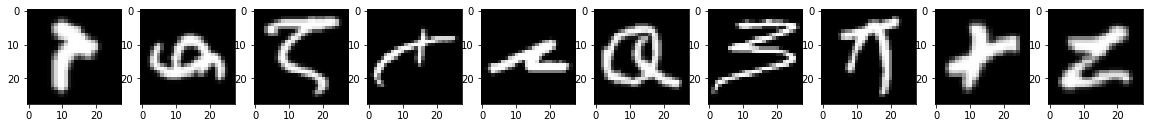

In [7]:
fig, ax = plt.subplots(1, 10, figsize=(20, 6))
for i in range(10):
    ax[i].imshow(X_train[i].reshape([28, 28]),cmap=plt.get_cmap('gray'))

In [8]:
def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28 * 28])
X_train = np.apply_along_axis(rotate, 1, X_train)
X_test = np.apply_along_axis(rotate, 1, X_test)

In [9]:
X_train = 255 - X_train
X_test = 255 - X_test

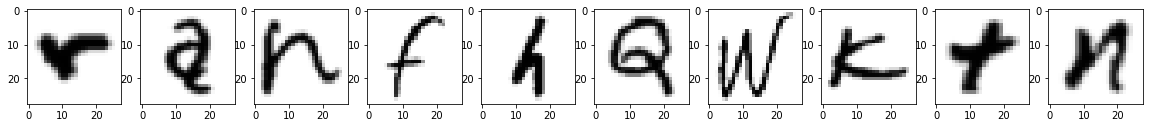

In [10]:
fig, ax = plt.subplots(1, 10, figsize=(20, 6))
for i in range(10):
    ax[i].imshow(X_train[i].reshape([28, 28]),cmap=plt.get_cmap('gray'))

# Preprocessing

In [11]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

X_train.shape

(88800, 28, 28, 1)

In [12]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

In [13]:
X_all = np.concatenate((X_train, X_test))
y_all = np.concatenate((y_train,  y_test))

del X_train, X_test, y_train, y_test

# Model Fitting

In [14]:
from sklearn.metrics import confusion_matrix, classification_report

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


## Convolutional Neural Network

In [16]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
filepath = "lens-alpha.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(patience=2)

def cnn(image_size):
    classifier = Sequential()
    classifier.add(Conv2D(32, (3, 3), input_shape = (*image_size, 1), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(units = 37, activation = 'softmax'))
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    classifier.summary()
    return classifier


model = cnn((28,28))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 37)                200133    
Total params: 200,453
Trainable params: 200,453
Non-trainable params: 0
_________________________________________________________________


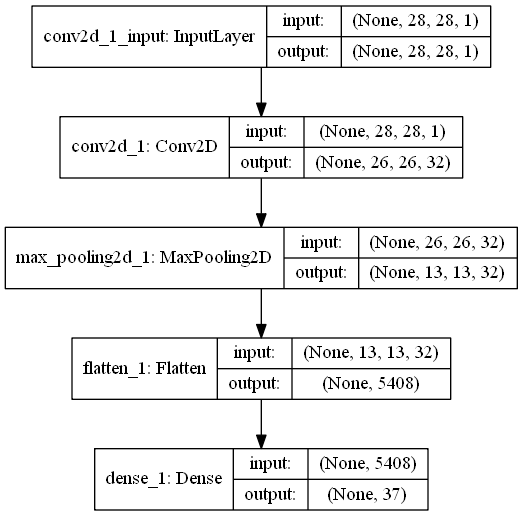

In [17]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='CNN.png', show_shapes=True, show_layer_names=True)

In [18]:
history = model.fit(X_all, y_all, validation_split=0.1, epochs=1000, callbacks=[es, ckpt, rlp])

Train on 93240 samples, validate on 10360 samples
Epoch 1/1000
93240/93240 [==============================] - 40s 428us/step - loss: 0.7663 - accuracy: 0.7846 - val_loss: 0.5379 - val_accuracy: 0.8411

Epoch 00001: loss improved from inf to 0.76625, saving model to lens-alpha.h5
Epoch 2/1000
93240/93240 [==============================] - 40s 431us/step - loss: 0.4370 - accuracy: 0.8689 - val_loss: 0.4671 - val_accuracy: 0.8616

Epoch 00002: loss improved from 0.76625 to 0.43696, saving model to lens-alpha.h5
Epoch 3/1000
93240/93240 [==============================] - 40s 431us/step - loss: 0.3776 - accuracy: 0.8847 - val_loss: 0.4406 - val_accuracy: 0.8707

Epoch 00003: loss improved from 0.43696 to 0.37760, saving model to lens-alpha.h5
Epoch 4/1000
93240/93240 [==============================] - 40s 424us/step - loss: 0.3399 - accuracy: 0.8936 - val_loss: 0.4415 - val_accuracy: 0.8722

Epoch 00004: loss improved from 0.37760 to 0.33989, saving model to lens-alpha.h5
Epoch 5/1000
93240

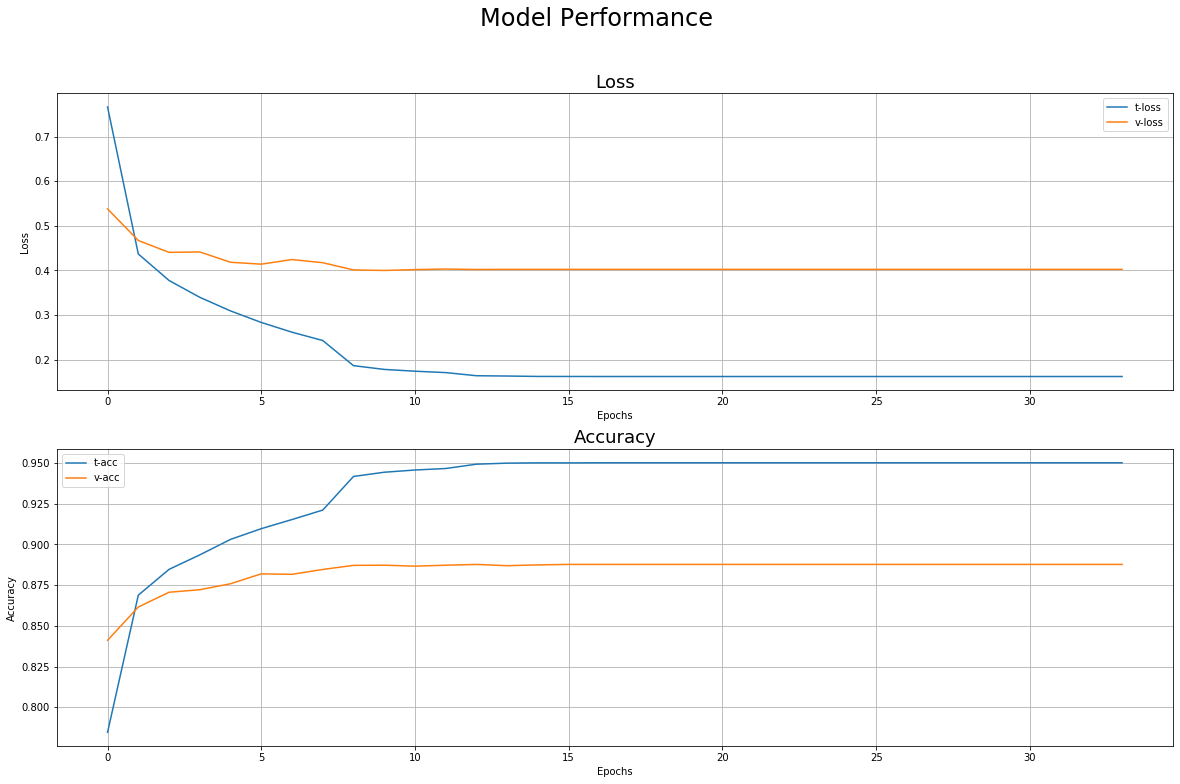

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

fig.suptitle('Model Performance', fontsize=24) 

ax[0].plot(history.history['loss'], label='t-loss')
ax[0].plot(history.history['val_loss'], label='v-loss')
ax[0].set_title('Loss', fontsize=18)
ax[0].set_ylabel('Loss')

ax[1].plot(history.history['accuracy'], label='t-acc')
ax[1].plot(history.history['val_accuracy'], label='v-acc')
ax[1].set_title('Accuracy', fontsize=18)
ax[1].set_ylabel('Accuracy')


for i in range(2):
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel('Epochs')
    
plt.savefig('Training.png')    